# Solving for probe and object with minibatches

In [4]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import skimage, skimage.transform, skimage.data
import skimage.feature, skimage.restoration
from helper import *

## Generating the object, the probe, and the diffraction intensities (with Poisson noise) ##

In [5]:
# Generating the object and the probe. 
# For convenience, I am not setting the detector pixel pitch - just working directly with the object plane 
obj_npix = 128
probe_npix = 64
n_photons = 1e6

gaussian_beam_stdev_pixels = 7
gaussian_intensity = getGaussian2D(probe_npix, stdev=gaussian_beam_stdev_pixels)
gaussian_ampl = gaussian_intensity**0.5

speckle = getSpeckle(probe_npix, 10)

probe_true = speckle * gaussian_ampl
probe_true = probe_true * np.sqrt(n_photons / np.sum(np.abs(probe_true)**2))
obj_true = getSampleObj(npix=obj_npix)

In [6]:
# Generating diffraction patterns for the given number of scan points (in a square grid)
# Calculates the position so that the probe view always fits inside the object dimensions.
# Calculates the position so that the probe view always fits inside the object dimensions.
num_scan_steps_x = 20
px = np.floor(np.linspace(0, obj_npix - probe_npix, num_scan_steps_x)).astype('int')
grid_positions = np.array([(p1, p2) for p1 in px for p2 in px])

diff_intensities = []

for y, x in grid_positions:
    exit_wave = obj_true[y: y + probe_npix, x: x + probe_npix] * probe_true
    exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
    diff_temp = np.abs(exit_wave_ft)**2
    diff_intensities.append(diff_temp)
        
diff_intensites = np.array(diff_intensities)
# Adding poisson noise
diff_intensities = np.random.poisson(diff_intensities)

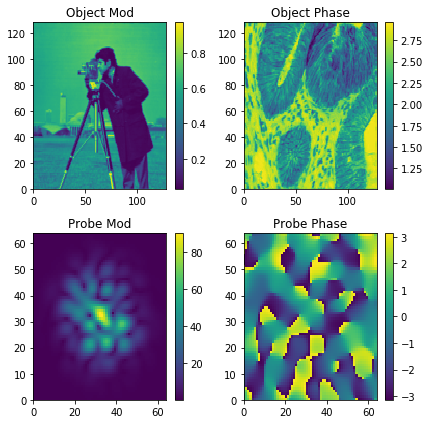

In [7]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_true), np.angle(obj_true), np.abs(probe_true), np.angle(probe_true)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

### Object and probe initialization
* Initialize the probe with a backpropagation
* Random initalization for the object


In [8]:
probe_init = np.fft.fftshift(np.fft.ifft2(np.mean(np.sqrt(diff_intensities), axis=0)))
obj_init = np.random.random(obj_true.shape) * np.exp(1j * np.pi * np.random.random(obj_true.shape))

## Remove discontinuties in probe phase
angs = np.angle(probe_init)
angs[::2] += np.pi
angs[:,::2] += np.pi
probe_init = np.abs(probe_init) * np.exp(1j * angs)

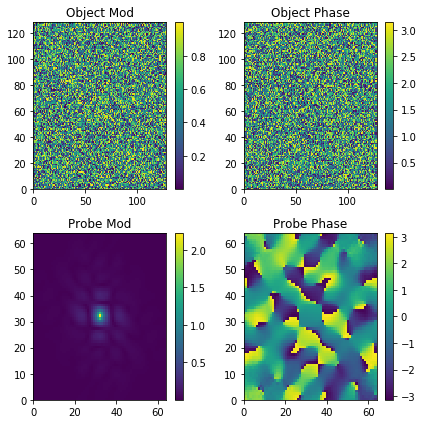

In [9]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_init), np.angle(obj_init), np.abs(probe_init), np.angle(probe_init)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

### Tensorflow reconstruction

**Notes about minibatches**:
* The TensorFlow Dataset framework makes it very convenient to use minibatches for the reconstruction.
* When the diffraction data set is small enough to easily fit in the GPU memory, we can take advantage of this to avoid I/O bottlenecks. For larger datasets, we have to adopt a slightly different minibatching strategy.
* In the scenario that the dataset fits into the GPU memory (which we shall assume as a given from now on), we can adopt the strategy:
    1) pre-calculate which (subset of) object pixels the probe interacts with at each scan position. We call these *obj_views*. Ensure that the order of stacking of these *obj_views* match with the order of stacking of the diffraction patterns. 
    2) create a list $[0,1,...,N-1]$ where $N$ is the number of diffraction patterns. Randomly select minibatches from this list (without replacement), then use the corresponding *obj_view* and diffraction intensity for further calculation.
    3) Use the *iterator* framework from TensorFlow to generate these minibatches.
* Inconveniently, when we use *iterators*, the minbatches of *obj_views* and diffraction patterns thus generated are not stored in the memory---every time we access the *iterator*, we get a new minibatch. In other words, there is no temporary storage to store this intermediate information at every step. If we want to do finer analysis on the minibatches, we might want this information.
* For this temporary storage, we can use a TensorFlow *Variable* object, and store the minibatch information in the variable using an *assign* operation. The values of TensorFlow variables change ***only*** when we use these assign operations. In effect, we only access the iterator when we assign the value to the variable. Otherwise, the value of the variable remains in memory, unconnected to the iterator. Thus the minibatch information is preserved until we use the assign operation again.

In [10]:
# Creating the variables for the reconstruction

tf.reset_default_graph()
tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')

tf_probe_real = tf.Variable(np.real(probe_init), dtype='float32')
tf_probe_imag = tf.Variable(np.imag(probe_init), dtype='float32')

tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
tf_probe = tf.complex(tf_probe_real, tf_probe_imag)

ndiffs, npix, _ = diff_intensities.shape
shifted_intensities = np.fft.fftshift(diff_intensities, axes=(1,2))
tf_intensities = tf.constant(shifted_intensities, dtype='float32')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Defining the amplitude-based loss, using the entire data set at once.
# Creating batches is somewhat complicated, and beyond the scope of this notebook.
# This implmentation is simple conceptually but not the most efficient.
tf_obj_views_all = []
for i, (y, x) in enumerate(grid_positions):
    this_obj_view = tf_obj[y: y + npix, x: x + npix]
    tf_obj_views_all.append(this_obj_view)

tf_obj_views_all = tf.stack(tf_obj_views_all)

In [14]:
# Using minibatches
dataset_indices = tf.data.Dataset.range(ndiffs)
# ask tensorflow to indefinitely regenerate the same indices every time we run out.
dataset_indices =  dataset_indices.repeat()
# Randomly shuffle the indices every time we run out
dataset_indices = dataset_indices.shuffle(buffer_size=ndiffs)

# Set the batch
batch_size = 100
dataset_batch = dataset_indices.batch(batch_size, drop_remainder=True)
dataset_batch = dataset_batch.apply(tf.data.experimental.prefetch_to_device('/gpu:0',10))

In [16]:
# Create the iterator
iterator = dataset_batch.make_one_shot_iterator()

batchi = iterator.get_next()

# Create the variable for temporary storage of the minibatch information
batch_indices = tf.Variable(tf.zeros(batch_size, dtype=tf.int64), trainable=False)

# Create the operation that updates the values in the batch_indices variable.
assign_op = batch_indices.assign(batchi)


batch_intensities = tf.gather(tf_intensities, batch_indices)
batch_obj_views = tf.gather(tf_obj_views_all, batch_indices)

In [18]:
tf_exit_waves = batch_obj_views * tf_probe
tf_fts = tf.fft2d(tf_exit_waves) / npix
loss = tf.reduce_mean((tf.abs(tf_fts) - tf.sqrt(batch_intensities))**2)

In [19]:
# For simplicity, I am using the Adam optimizer. 
# Using the lipschitz constants for the learning rates in a gradient descent process is quite complicated. 

# The learning rates were obtained through trial and error.
obj_optimizer = tf.train.AdamOptimizer(1e-2)
probe_optimizer = tf.train.AdamOptimizer(1e0)

probe_min = probe_optimizer.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
obj_min = obj_optimizer.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])

Instructions for updating:
Use tf.cast instead.


In [27]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [28]:
lossvals_array = []

In [29]:
# Actual minimization procedure. 
# Minimizing both the probe and the object simultaneously.
# At every iteration, use a new minibatch
for i in range(500):
    session.run(assign_op)
    temp1, temp2, lossval = session.run([probe_min, obj_min, loss])
    if i % 50 == 0:
        print('Iterations = {i}   Loss = {lossval}'.format(i=i, lossval=lossval))
    
    lossvals_array.append(lossval)
    
    if lossval < 1e-5:
        break

recons_obj = session.run(tf_obj)
recons_probe = session.run(tf_probe)
print('Current loss is', lossvals_array[-1])

Iterations = 0   Loss = 51.62946319580078
Iterations = 50   Loss = 8.323485374450684
Iterations = 100   Loss = 5.158832550048828
Iterations = 150   Loss = 4.431356430053711
Iterations = 200   Loss = 3.725909471511841
Iterations = 250   Loss = 2.172311305999756
Iterations = 300   Loss = 0.3856724500656128
Iterations = 350   Loss = 0.28612351417541504
Iterations = 400   Loss = 0.2851155400276184
Iterations = 450   Loss = 0.26718783378601074
Current loss is 0.2729535


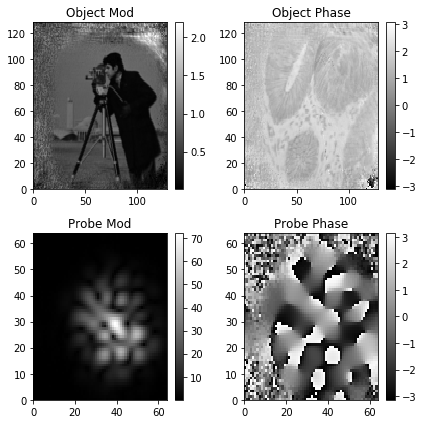

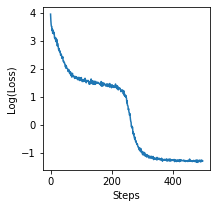

In [30]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(recons_obj), np.angle(recons_obj),
              np.abs(recons_probe), np.angle(recons_probe)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item, cmap='gray')
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

plt.figure(figsize=[3,3])
plt.plot(np.log(lossvals_array))
plt.xlabel('Steps')
plt.ylabel('Log(Loss)')
plt.show()

In [31]:
# Calculating the reconstruction errors using the plane fitting procedure
# Note that the error thus calculated does not account for the lack of probe overlap at the edges of the object.
# Hence, the error calculated is an overestimate.
imgs, errs = registerImages(obj_true, recons_obj)
print('Reconstruction error', errs[1])


Reconstruction error 0.3919311948680024


/raid/home/skandel/code/ptychoSampling_v2/tensorflow_tutorials/helper.py:147: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, residuals, rank, s = np.linalg.lstsq(a, b)
